# Configs

In [356]:
%load_ext autoreload
%autoreload 3
## other standard packages
import os
import sys
## Env variables and preparation stuffs
sys.path.insert(0, "../")
from src_code.task_utils.config_parser import ConfigParser
configs_dict = {
    "data_configs": {
        "train_path": "datasets/utn_dataset_curated/part2/train",
        "val_path": "datasets/utn_dataset_curated/part2/val",
        "test_path": "datasets/utn_dataset_curated/part2/test",
        "preprocessing_related": {
            "mean": 0.5,  # for raw_image normalisation
            "std": 0.5,  # for raw_image normalisation
            "downscale_factor": 4,
        },
        "dataset_related": {
            "preprocessed_dir": "../datasets/utn_dataset_curated/part2/train/preprocessed",
            "labels_dir": "../datasets/utn_dataset_curated/part2/train/labels",
            "augment": True,
            "shuffle": False,
        },
        "augmentation_related": {
            "flip_prob": 0,
            "scale_range": (0.8, 1.2),
            "zoom_prob": 1,
            "saturation_prob": 0
        },
    },
    "model_configs": {
        "epochs": 1,
        "batch_size": 32,
        "device": "cuda",  # either "cpu" or "cuda"
        "checkpoint": None,
        "backbone": {
            "name": "VGG16",
            "num_stages": 6,
        },
        "loss": {
            "alpha": 1,  # loss = alpha*loc_loss + cls_loss
            "pos_box_threshold": 0.5,  # a default box is marked positive if it has (> pos_box_threshold) IoU score with any of the groundtruth boxes
            "hard_neg_pos": 3,  # num of negative boxes = hard_neg_pos * num_positive_boxes
        },
        "optim": {
            "name": "SGD",
            "lr": 0.001,
            "momentum": 0.9,
            "weight_decay": 0.0005,
        },
        "scheduler": {
            "name": "MultiStepLR",
            "milestones": [155, 195],
            "gamma": 0.1,
        },
    },
    "task_configs": {
        "img_height": 160,  # original image height
        "img_width": 640,  # original image width
        "debug": True,  # if True will display a lot of intermediate information for debugging purposes
        "log_expt": False,  # whether to log the experiment online or not
        "num_classes": 37,  # A-Z(26), 0-9(10), background(1)
        "min_cls_score": 0.01,  # if the cls score for a bounding box is less than this, it is considered as background
        "nms_iou_score": 0.1,  # if the iou between two bounding boxes is less than this, it is suppressed
    },
}
# hyperparameters
preprocessed_dir = "../datasets/utn_dataset_curated/part2/train/preprocessed"
labels_dir = "../datasets/utn_dataset_curated/part2/train/labels"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Imports

In [357]:
import torch
from torchvision.utils import draw_bounding_boxes
import matplotlib.pyplot as plt

In [358]:
config = ConfigParser(configs_dict).get_parser()
print(config.__dict__)  # Check all attributes in config

# this object can be used as follows:
print(f"{config.pos_box_threshold = }")

config = {'data_configs': {'train_path': 'datasets/utn_dataset_curated/part2/train', 'val_path': 'datasets/utn_dataset_curated/part2/val', 'test_path': 'datasets/utn_dataset_curated/part2/test', 'preprocessing_related': {'mean': 0.5, 'std': 0.5, 'downscale_factor': 4}, 'dataset_related': {'preprocessed_dir': '../datasets/utn_dataset_curated/part2/train/preprocessed', 'labels_dir': '../datasets/utn_dataset_curated/part2/train/labels', 'augment': True, 'shuffle': False}, 'augmentation_related': {'flip_prob': 0, 'scale_range': (0.8, 1.2), 'zoom_prob': 1, 'saturation_prob': 0}}, 'model_configs': {'epochs': 1, 'batch_size': 32, 'device': 'cuda', 'checkpoint': None, 'backbone': {'name': 'VGG16', 'num_stages': 6}, 'loss': {'alpha': 1, 'pos_box_threshold': 0.5, 'hard_neg_pos': 3}, 'optim': {'name': 'SGD', 'lr': 0.001, 'momentum': 0.9, 'weight_decay': 0.0005}, 'scheduler': {'name': 'MultiStepLR', 'milestones': [155, 195], 'gamma': 0.1}}, 'task_configs': {'img_height': 160, 'img_width': 640, 'de

In [4]:
# note: change to relative import using a dot (.) in datautils line 4 & 5

# 0. Dataloader

In [359]:
print(sys.path)
from src_code.data_utils.dataset_utils import CaptchaDataset, get_dataloader
from src_code.data_utils.augmentation import Augmentations
# if the preprocessed dataset is not available, run create it using src_code/data_utils/preprocessing.py

# Create dataset
dataset = CaptchaDataset(config)

# Load a sample
image, bboxes, labels = dataset[0]

print("Image Shape:", image.shape)
print("Bounding Boxes:", bboxes)
print("Labels:", labels)


# Create DataLoader
dataloader = get_dataloader(dataset, config)

# Load a single batch
images, bboxes, labels = next(iter(dataloader))

# Print batch info
print(f"Batch Image Shape: {images.shape}")
print(f"Bounding Boxes (First Image): {bboxes[0]}")
print(f"Labels (First Image): {labels[0]}")


['../', '../', '../', '../', '../', '../', '../', '../', '../', '../', '../', '../', '../', '../', '../', '../', '../', '../', '../', '../', '../', '../', '/Library/Frameworks/Python.framework/Versions/3.11/lib/python311.zip', '/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11', '/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/lib-dynload', '', '/Users/lucaheller/Desktop/UTN_Captcha_Detector/.venv/lib/python3.11/site-packages', '/var/folders/ph/4ppm8f8950g15_ff9t0m53k80000gn/T/tmp6h8mv_hx']
Image Shape: torch.Size([1, 40, 160])
Bounding Boxes: tensor([[0.3793, 0.0688, 0.6011, 0.9485]])
Labels: tensor([24])
Batch Image Shape: torch.Size([5, 1, 40, 160])
Bounding Boxes (First Image): tensor([[0.0669, 0.5308, 0.1555, 1.0000],
        [0.3584, 0.0000, 0.5609, 0.5765],
        [0.4941, 0.1833, 0.6922, 0.9927]])
Labels (First Image): tensor([21,  3, 24])


Image Shape: torch.Size([1, 40, 160])
Bounding Boxes: tensor([[0.1459, 0.1422, 0.3600, 1.0000],
        [0.7948, 0.0000, 1.0000, 0.8455]])
Labels: tensor([21,  0])
BBoxes for Visualization: tensor([[ 23,   5,  57,  40],
        [127,   0, 160,  33]], dtype=torch.int32)


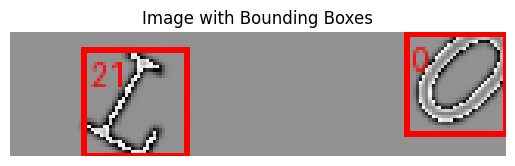

In [360]:

# dataset = CaptchaDataset(preprocessed_dir, labels_dir, downscale_factor=False, augment=True)
# Load one sample for visualization
image, bboxes, labels = dataset[0]

print("Image Shape:", image.shape)
print("Bounding Boxes:", bboxes)
print("Labels:", labels)


def plot_image_with_bboxes(image, bboxes, labels, title="Image with Bounding Boxes"):
    img_height, img_width = image.shape[1], image.shape[2] 
    
    # Scale normalized bboxes to absolute pixel values for visualization
    # TODO: --> * 4 used for non flipped images: works
    # Issue with flipped ones
    # How to test: set flip prob to one and you will see :)
    bboxes[:, [0, 2]] *= img_width
    bboxes[:, [1, 3]] *= img_height

    # Convert to integer values for plotting
    bboxes_abs = bboxes.to(torch.int)

    print("BBoxes for Visualization:", bboxes_abs)

    # Ensure labels are strings
    if isinstance(labels, torch.Tensor):
        labels = labels.tolist()
    labels = [str(l) for l in labels]

    # TODO: Image to RGB

    # Draw bboxes
    image_with_boxes = draw_bounding_boxes(image, bboxes_abs, labels=labels, colors="red", width=2)

    # image tensor to NumPy for visualization
    img = image_with_boxes.permute(1, 2, 0).numpy()

    plt.imshow(img)
    plt.axis("off")
    plt.title(title)
    plt.show()


plot_image_with_bboxes(image, bboxes, labels)


# 1. Model

In [7]:
from src_code.model_utils.backbone import VGG16Backbone
from src_code.model_utils.ssd import SSD

# Initialize the SSD model
model = SSD(num_classes=config.num_classes)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Print model summary
print(model)

C:\Users\irene\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\irene\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


SSD(
  (backbone): VGG16Backbone(
    (features): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
   

## 1.1 Model Architecture

In [8]:
print(model.backbone)
print(model.auxiliary_convs)
print(model.loc_head)
print(model.cls_head)

VGG16Backbone(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, 

## 1.2 Loss Function

In [9]:
from src_code.model_utils.loss import MultiBoxLoss
default_boxes = torch.Tensor([[0.5000, 0.1250, 0.5000, 0.1250],[0.5000, 0.3750, 0.5000, 0.1250],
        [0.5000, 0.6250, 0.5000, 0.1250],[0.5000, 0.8750, 0.5000, 0.1250],
        [0.5000, 0.1250, 0.5000, 0.0625],[0.5000, 0.3750, 0.5000, 0.0625],
        [0.5000, 0.6250, 0.5000, 0.0625],[0.5000, 0.8750, 0.5000, 0.0625]])
# (1, 8, 4)
locs_pred = torch.Tensor([[[0., 0., 0., 0.],
                     [0., 0., 0., 0.],
                     [0., 0., 0., 0.],
                     [0., 0., 0., 0.],
                     [0., 0., 0., 0.],
                     [0., 0., 0., 0.],
                     [0., 0., 0., 0.],
                     [0., 0., 0., 0.]]])

# (1, 8, 36)
cls_pred = torch.Tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
      0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
      0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.9000, 0.0000, 0.0000,
      0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
      0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
     [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
      0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
      0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
      0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
      0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
     [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
      0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
      0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.9000, 0.0000, 0.0000,
      0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
      0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
     [0.0000, 0.0000, 0.0000, 0.0000, 0.9000, 0.0000, 0.0000, 0.0000,
      0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
      0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
      0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
      0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
     [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
      0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
      0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.9000, 0.0000, 0.0000,
      0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
      0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
     [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
      0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
      0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
      0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
      0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
     [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
      0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
      0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.9000, 0.0000, 0.0000,
      0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
      0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
     [0.0000, 0.0000, 0.0000, 0.0000, 0.9000, 0.0000, 0.0000, 0.0000,
      0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
      0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
      0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
      0.0000, 0.0000, 0.0000, 0.0000, 0.0000]]])
boxes = torch.Tensor([[[ 61,  36, 139, 115], [297,  10, 386,  98], [509,  26, 572,  90]]])
labels = torch.Tensor([[21,  0, 33]])

# calculate loss
mbl = MultiBoxLoss(default_boxes, config)
loss, debug_info = mbl(locs_pred, cls_pred, boxes, labels)
expected_loss = 10.8635

C:\Users\irene\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


In [10]:
loss

tensor(291.2195)

In [11]:
debug_info

{'overlap_gt_def_boxes': [tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0.]])],
 'db_for_each_obj': [tensor([0, 0, 0])],
 'db_indices_for_each_obj': [tensor([0, 0, 0])],
 'overlap_value_for_each_db': tensor([1., 0., 0., 0., 0., 0., 0., 0.]),
 'self.label_each_db': [tensor([33., 36., 36., 36., 36., 36., 36., 36.])],
 'match': [tensor([ True, False, False, False, False, False, False, False])],
 'gt_locs': [tensor([[  19.0000, 1071.0000,    5.8158,   12.6685],
          [  27.7500,  170.0000,    6.8686,   13.7364],
          [  27.7500,  150.0000,    6.8686,   13.7364],
          [  27.7500,  130.0000,    6.8686,   13.7364],
          [  27.7500,  380.0000,    6.8686,   17.2021],
          [  27.7500,  340.0000,    6.8686,   17.2021],
          [  27.7500,  300.0000,    6.8686,   17.2021],
          [  27.7500,  260.0000,    6.8686,   17.2021]]),
  tensor([[  19.0000, 1071.0000,    5.8158,   12.6685],
         

# 2. Training

In [19]:
from torch.optim import SGD
from src_code.model_utils.train_utils import CaptchaTrainer

config = ConfigParser(configs_dict)
config = config.get_parser()

# Automatically detect if CUDA is available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Ensure `config.device` is updated correctly
config.device = device

# Move model to the correct device
model.to(config.device)
print(f"Using device: {config.device}")

# Ensure default boxes are defined
print(f"Default boxes shape: {default_boxes.shape}")  # Check before passing

# Ensure dataloader has data
assert len(dataloader) > 0, "Error: Training dataloader is empty!"
print(f"Number of batches in train_loader: {len(dataloader)}")

print(f"config attributes: {dir(config)}")  # Check attributes exist
print(f"config.pos_box_threshold: {config.pos_box_threshold}")  # Ensure it's defined

# Create optimizer
optimizer = SGD(
    model.parameters(),
    lr=config.lr,  # Use object attribute instead of dictionary key
    momentum=config.momentum,
    weight_decay=config.weight_decay
)

# Define loss function
loss_fn = MultiBoxLoss(default_boxes, config)

# Create trainer
trainer = CaptchaTrainer(
    model=model,
    train_loader=dataloader,
    val_loader=None,  # You can set a validation loader if needed
    test_loader=None,  # You can set a test loader if needed
    loss_fn=loss_fn,
    optimizer=optimizer,
    config=config
)

# Train the model
num_epochs = config.epochs
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}:")
    trainer.train_step(epoch)
    print("---------------------------------------------")

print("Training complete!")


config = {'data_configs': {'train_path': 'datasets/utn_dataset_curated/part2/train', 'val_path': 'datasets/utn_dataset_curated/part2/val', 'test_path': 'datasets/utn_dataset_curated/part2/test', 'preprocessing_related': {'mean': 0.5, 'std': 0.5, 'downscale_factor': 4}, 'dataset_related': {'preprocessed_dir': '../datasets/utn_dataset_curated/part2/train/preprocessed', 'labels_dir': '../datasets/utn_dataset_curated/part2/train/labels', 'augment': True, 'shuffle': False}, 'augmentation_related': {'flip_prob': 0.5, 'scale_range': (0.8, 1.2)}}, 'model_configs': {'epochs': 1, 'batch_size': 32, 'device': 'cuda', 'checkpoint': None, 'backbone': {'name': 'VGG16', 'num_stages': 6}, 'loss': {'alpha': 1, 'pos_box_threshold': 0.5, 'hard_neg_pos': 3}, 'optim': {'name': 'SGD', 'lr': 0.001, 'momentum': 0.9, 'weight_decay': 0.0005}, 'scheduler': {'name': 'MultiStepLR', 'milestones': [155, 195], 'gamma': 0.1}}, 'task_configs': {'img_height': 160, 'img_width': 640, 'debug': True, 'log_expt': False, 'num_

IndexError: The shape of the mask [5, 8] at index 1 does not match the shape of the indexed tensor [5, 80, 4] at index 1

# 3. Evaluation